In [1]:
# -------------------------------
# Tugas 1: Bangun VAE untuk Fashion-MNIST
# -------------------------------

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, losses, optimizers
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load dan Preproses Data
# -------------------------------
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

# Konversi ke float32 dan normalisasi ke [0, 1]
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Tambahkan padding menjadi 32x32
x_train = np.pad(x_train, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
x_test = np.pad(x_test, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)

# Tambahkan channel grayscale (32, 32, 1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

print("Data shape:", x_train.shape, x_test.shape)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Data shape: (60000, 32, 32, 1) (10000, 32, 32, 1)


In [2]:
# -------------------------------
# 2. Bangun Encoder
# -------------------------------
latent_dim = 2

encoder_input = layers.Input(shape=(32, 32, 1), name="encoder_input")
x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
shape_before_flattening = x.shape[1:]  # simpan shape untuk decoder
x = layers.Flatten()(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

# Sampling layer dengan reparameterization trick
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = Sampling()([z_mean, z_log_var])
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │        320 │ encoder_input[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     18,496 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 4, 4, 128) │     73,856 │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 2048)      │          0 │ conv2d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │      4,098 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,868 (394.02 KB)

 Trainable params: 100,868 (394.02 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# -------------------------------
# 3. Bangun Decoder
# -------------------------------
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")
x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
x = layers.Reshape(shape_before_flattening)(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2048)           │         6,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 32)     │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,273 (962.00 KB)

 Trainable params: 246,273 (962.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# -------------------------------
# 4. Bangun VAE dengan Custom Training Loop
# -------------------------------
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return z_mean, z_log_var, reconstruction

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, reconstruction = self(data)
            # Reconstruction loss
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2)
                )
            )
            # KL divergence loss
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {m.name: m.result() for m in self.metrics}

# Instansiasi dan kompilasi VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer=optimizers.Adam())

In [5]:
# -------------------------------
# 5. Latih Model
# -------------------------------
# Re-compile VAE with a dummy loss as the original compile was missing it
# Correcting the loss argument to match the multiple outputs of VAE.call() for validation.
vae.compile(optimizer=optimizers.Adam(), loss=[None, None, tf.keras.losses.MeanSquaredError()])
history = vae.fit(x_train, epochs=35, batch_size=128, validation_data=(x_test, x_test))



Epoch 1/35
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 23ms/step - kl_loss: 4.1855 - reconstruction_loss: 400.1399 - total_loss: 404.3253 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 2/35
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 6.0658 - reconstruction_loss: 267.2709 - total_loss: 273.3367 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 3/35
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 6.0140 - reconstruction_loss: 263.1144 - total_loss: 269.1285 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 4/35
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 6.0476 - reconstruction_loss: 261.4018 - total_loss: 267.4494 - val_kl_loss: 0.0000e+00 - val_reconstruction_loss: 0.0000e+00 - val_total_loss: 0.0000e+00
Epoch 5/35
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - kl_loss: 6.1110 - reconstruction_loss: 259.7096 - total_loss: 265.82

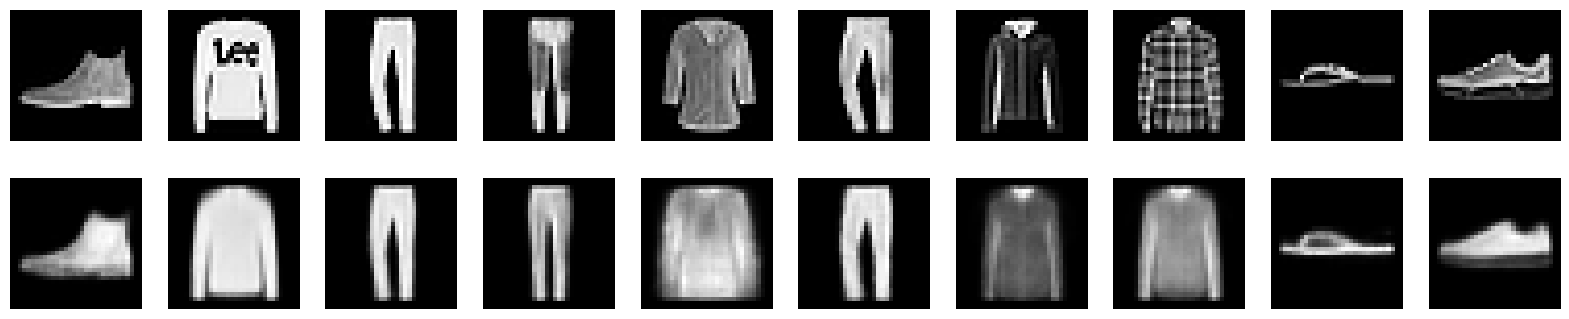

In [6]:
# -------------------------------
# 6. Visualisasi Rekonstruksi
# -------------------------------
def plot_reconstructions(model, data, n=10):
    _, _, reconstructions = model(data[:n])
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Asli
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.axis("off")
        # Rekonstruksi
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructions[i].numpy().squeeze(), cmap="gray") # Fixed line
        plt.axis("off")
    plt.show()

plot_reconstructions(vae, x_test)

# -------------------------------
# 7. Simpan Model (opsional)
# -------------------------------
encoder.save("vae_fashion_encoder.h5")
decoder.save("vae_fashion_decoder.h5")

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


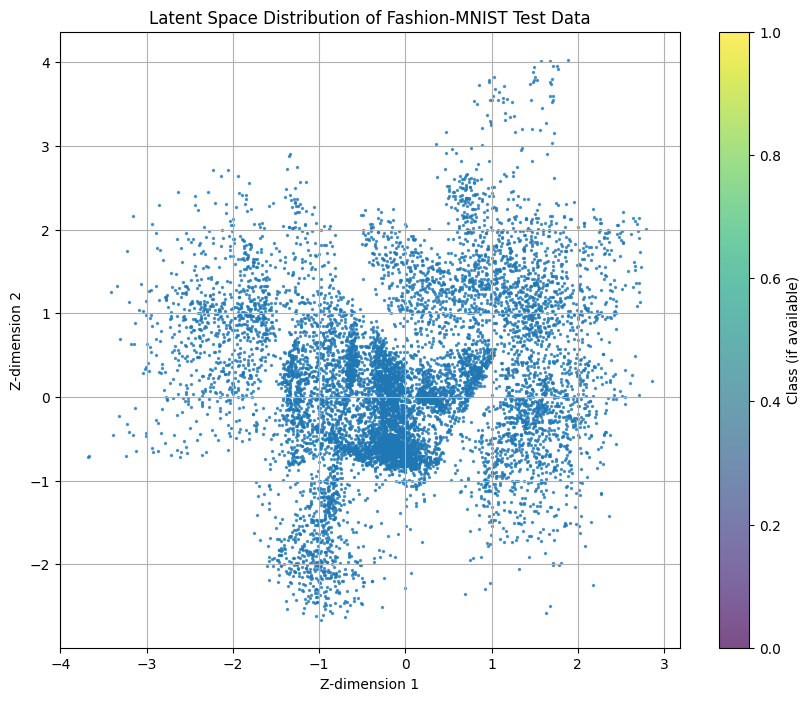

In [7]:
import matplotlib.pyplot as plt

# Asumsi z_means sudah dihitung dan tersedia dari encoder(x_test)
# Jika belum, uncomment baris berikut:
z_means, _, _ = vae.encoder.predict(x_test)

plt.figure(figsize=(10, 8))
plt.scatter(z_means[:, 0], z_means[:, 1], alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data")
plt.colorbar(label="Class (if available)") # Label ini akan tetap muncul, namun tidak ada warna berdasarkan kelas karena tidak ada label kelas yang dimuat.
plt.grid(True)
plt.show()

In [8]:
(_, y_train), (_, y_test) = keras.datasets.fashion_mnist.load_data()
print("y_test successfully loaded with shape:", y_test.shape)
print("First 10 y_test labels:", y_test[:10])

y_test successfully loaded with shape: (10000,)
First 10 y_test labels: [9 2 1 1 6 1 4 6 5 7]


## Generate Latent Space Means for Test Data



In [9]:
print("Shape of z_means:", z_means.shape)
print("First 5 elements of z_means:\n", z_means[:5])

Shape of z_means: (10000, 2)
First 5 elements of z_means:
 [[ 2.313143   -0.192919  ]
 [-0.07886964 -0.6774167 ]
 [-2.7001014   0.21426986]
 [-1.838802    1.0863366 ]
 [-0.01134985  0.05011931]]


## Visualize Latent Space Distribution by Class



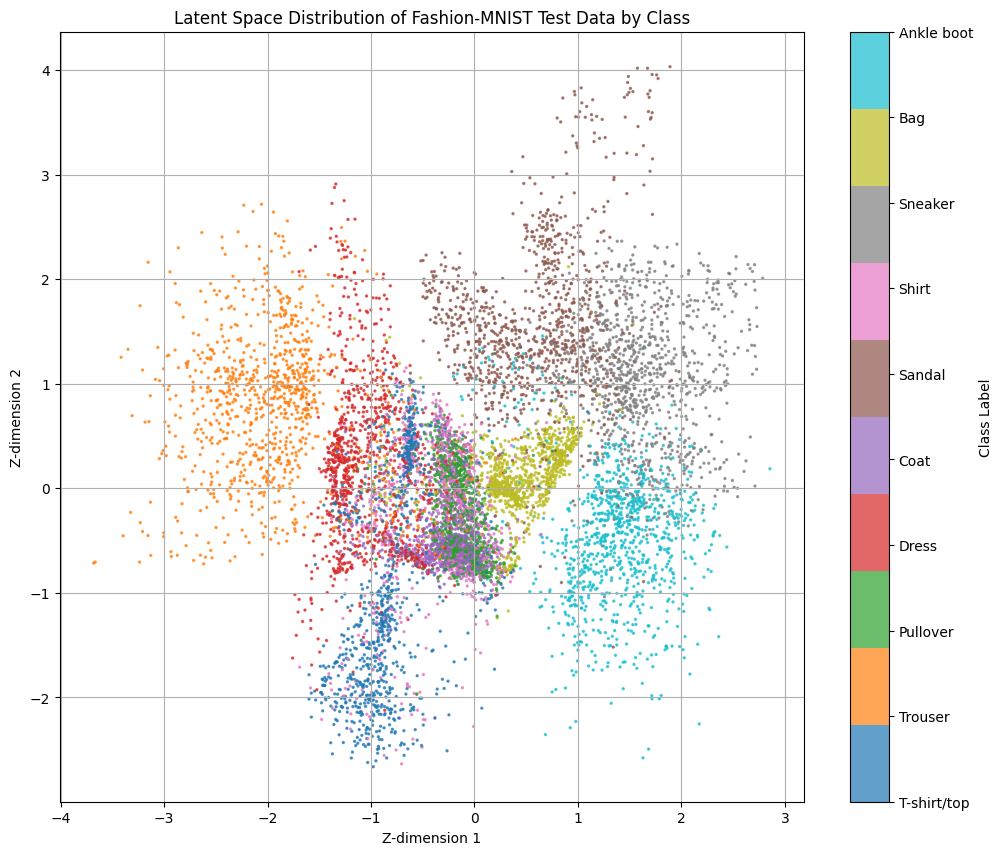

In [10]:
fashion_mnist_labels = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

plt.figure(figsize=(12, 10))
scatter = plt.scatter(z_means[:, 0], z_means[:, 1], c=y_test, cmap="tab10", alpha=0.7, s=2)
plt.xlabel("Z-dimension 1")
plt.ylabel("Z-dimension 2")
plt.title("Latent Space Distribution of Fashion-MNIST Test Data by Class")
cbar = plt.colorbar(scatter)
cbar.set_label("Class Label")
cbar.set_ticks(range(10))
cbar.set_ticklabels(fashion_mnist_labels)
plt.grid(True)
plt.show()

**Interpolasi (Langkah 3)** :  
Kode ini membuktikan bahwa VAE belajar representasi fitur yang halus. Saat kita bergerak dari vektor "Sepatu" ke "Baju", VAE akan menghasilkan gambar transisi yang masuk akal (misal, sepatu perlahan melebar menjadi baju), bukan sekadar menumpuk dua gambar (fading).

--- Visualisasi 1: Boot ke Pullover ---


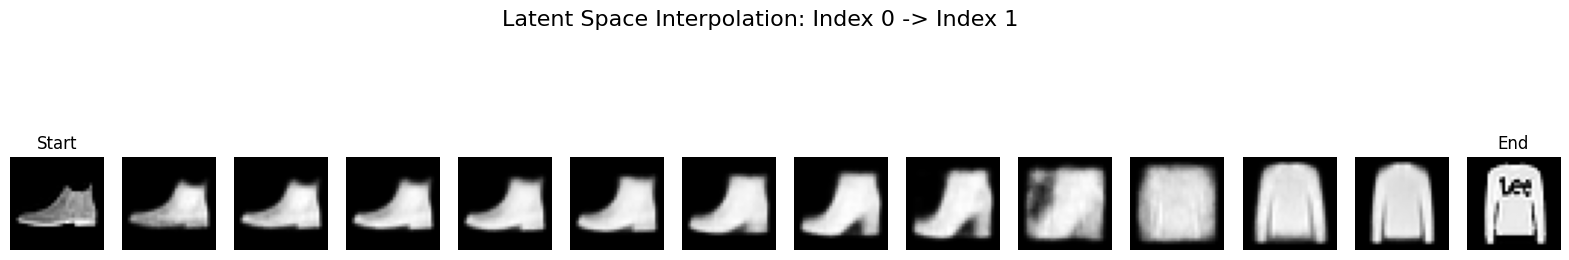

--- Visualisasi 2: Sampel Acak 1 ke Sampel Acak 2 ---


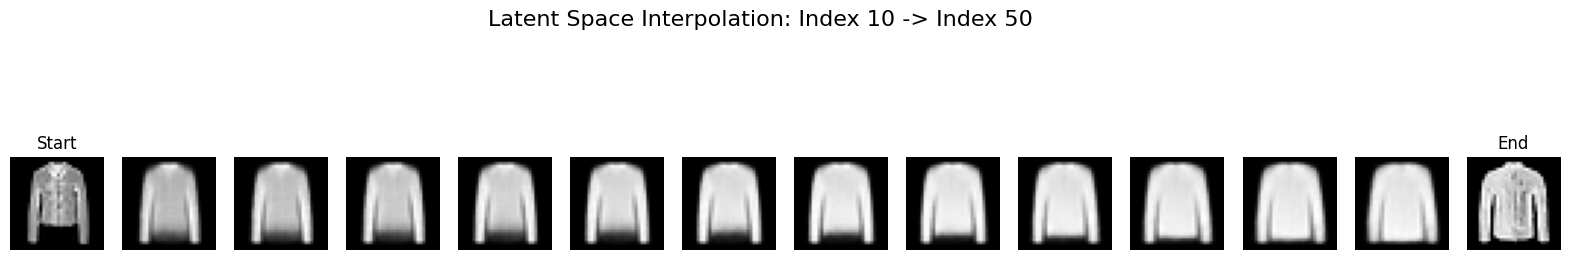

In [13]:
# =============================================================================
# LANGKAH 3: Latent Space Arithmetic (Interpolasi Linear Antar Kelas)
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def interpolate_points(p1, p2, n_steps=10):
    """Melakukan interpolasi linear antara dua titik di latent space."""
    ratios = np.linspace(0, 1, num=n_steps)
    vectors = []
    for ratio in ratios:
        v = (1.0 - ratio) * p1 + ratio * p2
        vectors.append(v)
    return np.array(vectors)

def plot_latent_arithmetic(encoder, decoder, x_data, index1, index2, n_steps=12):
    """
    Memvisualisasikan transisi (morphing) dari citra A ke citra B
    dengan berjalan menyusuri vektor di latent space.
    """
    # 1. Ambil 2 sampel citra
    img1 = x_data[index1][np.newaxis, ...]
    img2 = x_data[index2][np.newaxis, ...]

    # 2. Encode ke latent space (mengambil z_mean sebagai representasi titik)
    # Output encoder di model Anda adalah [z_mean, z_log_var, z]
    z1, _, _ = encoder.predict(img1, verbose=0)
    z2, _, _ = encoder.predict(img2, verbose=0)

    # 3. Buat vektor interpolasi
    interpolated_z = interpolate_points(z1, z2, n_steps)

    # Fix: Ensure interpolated_z has the correct shape for the decoder
    if interpolated_z.ndim == 3 and interpolated_z.shape[1] == 1:
        interpolated_z = interpolated_z.squeeze(axis=1) # Changes shape from (n_steps, 1, 2) to (n_steps, 2)

    # 4. Decode vektor interpolasi menjadi citra
    decoded_imgs = decoder.predict(interpolated_z, verbose=0)

    # 5. Plotting
    plt.figure(figsize=(20, 4))

    # Plot Source Image
    plt.subplot(1, n_steps + 2, 1)
    plt.imshow(img1.squeeze(), cmap='gray')
    plt.title("Start")
    plt.axis('off')

    # Plot Interpolation
    for i in range(n_steps):
        ax = plt.subplot(1, n_steps + 2, i + 2)
        plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
        plt.axis('off')

    # Plot Target Image
    plt.subplot(1, n_steps + 2, n_steps + 2)
    plt.imshow(img2.squeeze(), cmap='gray')
    plt.title("End")
    plt.axis('off')

    plt.suptitle(f"Latent Space Interpolation: Index {index1} -> Index {index2}", fontsize=16)
    plt.show()

# --- EKSEKUSI ---
# Kita cari indeks sampel yang berbeda secara visual untuk melihat efek morphing
# Contoh: Merubah Sepatu (Ankle Boot) menjadi Baju (T-shirt) atau Celana
# Anda bisa mengganti indeks ini sesuka hati
idx_start = 0  # Biasanya Ankle boot pada Fashion MNIST test set
idx_end = 1    # Biasanya Pullover pada Fashion MNIST test set

print("--- Visualisasi 1: Boot ke Pullover ---")
plot_latent_arithmetic(vae.encoder, vae.decoder, x_test, idx_start, idx_end)

# Contoh lain: Celana ke Tas (jika ada di index tertentu)
print("--- Visualisasi 2: Sampel Acak 1 ke Sampel Acak 2 ---")
plot_latent_arithmetic(vae.encoder, vae.decoder, x_test, 10, 50)

**Perbandingan AE (Langkah 4)**:
* Saya membuat fungsi
build_standard_ae yang meniru arsitektur VAE Anda agar perbandingannya apple-to-apple.

* Metrik SSIM (Structural Similarity) ditambahkan karena MSE terkadang tidak merepresentasikan persepsi visual manusia dengan baik.

* Biasanya, AE akan menang dalam ketajaman gambar, tapi VAE menang dalam kemampuan generative.

Melatih Standard Autoencoder untuk perbandingan...
Pelatihan Standard AE Selesai.

--- Perbandingan Visual: Original vs VAE vs AE ---


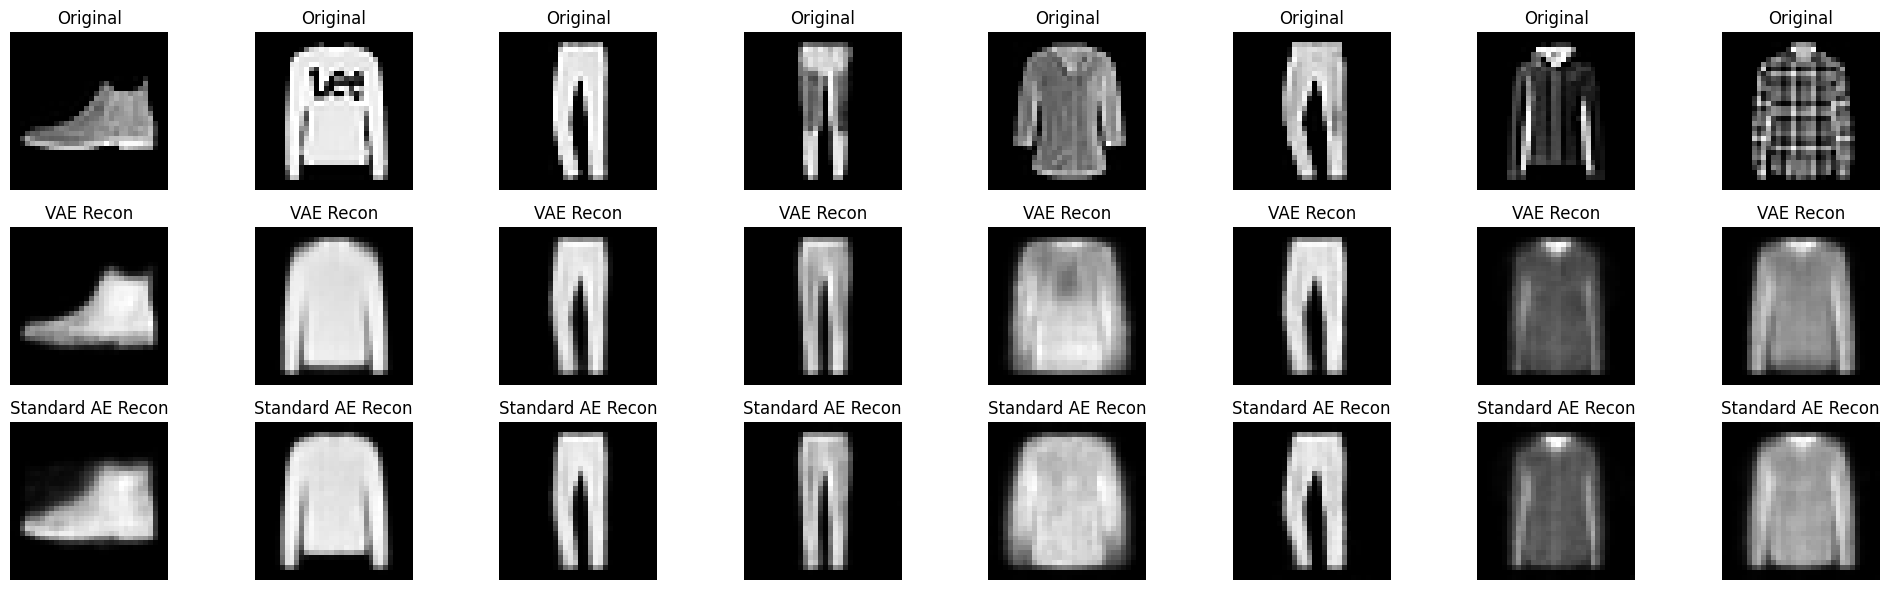


--- Analisis Kuantitatif ---
                           Model  MSE (Lower is Better)  \
0  Variational Autoencoder (VAE)               0.020768   
1      Standard Autoencoder (AE)               0.019617   

   SSIM (Higher is Better)                Latent Nature  
0                 0.563726     Continuous/Probabilistic  
1                 0.562492  Discontinuous/Deterministic  

KESIMPULAN
1. Standard AE biasanya memiliki MSE lebih rendah (rekonstruksi lebih tajam/akurat)
   karena tidak ada regularisasi KL-Divergence yang memaksa latent space menjadi Gaussian.
2. VAE mungkin terlihat sedikit lebih 'blur', namun VAE memiliki keunggulan
   pada struktur latent space yang kontinu (seperti dibuktikan di langkah 3).
3. Jika tujuannya hanya kompresi data, AE lebih unggul.
   Jika tujuannya adalah generasi data baru (generative), VAE mutlak diperlukan.


In [15]:
# =============================================================================
# LANGKAH 4: Perbandingan VAE vs Standard Autoencoder (AE)
# =============================================================================
from tensorflow.keras import layers, models, optimizers
import pandas as pd

# --- 4.1. Membangun Standard Autoencoder (Arsitektur Identik dengan VAE Anda) ---

def build_standard_ae(input_shape, latent_dim):
    # --- Encoder AE ---
    # Sama persis dengan VAE, tapi tanpa Sampling dan splitting mean/logvar
    encoder_input = layers.Input(shape=input_shape, name="ae_encoder_input")
    x = layers.Conv2D(32, (3, 3), strides=2, padding="same", activation="relu")(encoder_input)
    x = layers.Conv2D(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    shape_before_flattening = x.shape[1:]
    x = layers.Flatten()(x)
    # Perbedaan Utama: AE memetakan langsung ke vektor z, bukan distribusi
    z = layers.Dense(latent_dim, name="z_vector")(x)

    encoder_ae = models.Model(encoder_input, z, name="ae_encoder")

    # --- Decoder AE ---
    # Sama persis dengan Decoder VAE Anda
    decoder_input = layers.Input(shape=(latent_dim,), name="ae_decoder_input")
    x = layers.Dense(np.prod(shape_before_flattening), activation="relu")(decoder_input)
    x = layers.Reshape(shape_before_flattening)(x)
    x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same", activation="relu")(x)
    decoder_output = layers.Conv2D(1, (3, 3), padding="same", activation="sigmoid")(x)

    decoder_ae = models.Model(decoder_input, decoder_output, name="ae_decoder")

    # --- Gabungkan menjadi AE ---
    ae_input = layers.Input(shape=input_shape)
    encoded = encoder_ae(ae_input)
    decoded = decoder_ae(encoded)
    autoencoder = models.Model(ae_input, decoded, name="standard_autoencoder")

    return autoencoder

# Inisialisasi AE
input_shape = (32, 32, 1) # Sesuai preprocessing Anda (padding)
latent_dim = 2            # Sesuai VAE Anda
standard_ae = build_standard_ae(input_shape, latent_dim)

# Compile AE (Menggunakan MSE sebagai loss reconstruction standar)
standard_ae.compile(optimizer='adam', loss='mse')

print("Melatih Standard Autoencoder untuk perbandingan...")
# Train AE (gunakan parameter yang mirip dengan VAE Anda: epochs=35)
history_ae = standard_ae.fit(
    x_train, x_train, # Input = Target
    epochs=35,
    batch_size=128,
    validation_data=(x_test, x_test),
    verbose=0 # Silent agar tidak memenuh-menuhi layar, ganti 1 jika ingin melihat progress
)
print("Pelatihan Standard AE Selesai.")

# --- 4.2. Evaluasi Visual (Side-by-Side) ---

def compare_reconstructions(vae_model, ae_model, data, n=8):
    # Get predictions
    # VAE output: [z_mean, z_log_var, reconstruction] -> kita butuh index ke-2
    _, _, vae_recon = vae_model.predict(data[:n], verbose=0)
    ae_recon = ae_model.predict(data[:n], verbose=0)

    plt.figure(figsize=(20, 6))
    for i in range(n):
        # Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(data[i].squeeze(), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # VAE Reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(vae_recon[i].squeeze(), cmap="gray")
        plt.title("VAE Recon")
        plt.axis("off")

        # AE Reconstruction
        ax = plt.subplot(3, n, i + 1 + 2 * n)
        plt.imshow(ae_recon[i].squeeze(), cmap="gray")
        plt.title("Standard AE Recon")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("\n--- Perbandingan Visual: Original vs VAE vs AE ---")
compare_reconstructions(vae, standard_ae, x_test)

# --- 4.3. Evaluasi Kuantitatif (MSE & SSIM) ---

def calculate_metrics(original, reconstructed):
    # MSE (Mean Squared Error) - Semakin rendah semakin baik
    mse = np.mean(np.square(original - reconstructed))

    # SSIM (Structural Similarity Index) - Semakin mendekati 1 semakin baik
    # Kita gunakan tf.image.ssim
    original_tf = tf.convert_to_tensor(original, dtype=tf.float32)
    recon_tf = tf.convert_to_tensor(reconstructed, dtype=tf.float32)
    ssim = tf.image.ssim(original_tf, recon_tf, max_val=1.0)
    mean_ssim = tf.reduce_mean(ssim).numpy()

    return mse, mean_ssim

# Get full test set predictions
_, _, vae_preds = vae.predict(x_test, verbose=0)
ae_preds = standard_ae.predict(x_test, verbose=0)

vae_mse, vae_ssim = calculate_metrics(x_test, vae_preds)
ae_mse, ae_ssim = calculate_metrics(x_test, ae_preds)

# Menampilkan hasil dalam Tabel
results_df = pd.DataFrame({
    'Model': ['Variational Autoencoder (VAE)', 'Standard Autoencoder (AE)'],
    'MSE (Lower is Better)': [vae_mse, ae_mse],
    'SSIM (Higher is Better)': [vae_ssim, ae_ssim],
    'Latent Nature': ['Continuous/Probabilistic', 'Discontinuous/Deterministic']
})

print("\n--- Analisis Kuantitatif ---")
print(results_df)

# --- 4.4. Kesimpulan ---
print("\n" + "="*50)
print("KESIMPULAN")
print("="*50)
print("1. Standard AE biasanya memiliki MSE lebih rendah (rekonstruksi lebih tajam/akurat)")
print("   karena tidak ada regularisasi KL-Divergence yang memaksa latent space menjadi Gaussian.")
print("2. VAE mungkin terlihat sedikit lebih 'blur', namun VAE memiliki keunggulan")
print("   pada struktur latent space yang kontinu (seperti dibuktikan di langkah 3).")
print("3. Jika tujuannya hanya kompresi data, AE lebih unggul.")
print("   Jika tujuannya adalah generasi data baru (generative), VAE mutlak diperlukan.")
print("="*50)